In [1]:
from PIL import Image
import glob
import os
import cv2
import numpy as np
import random
import scipy.misc
from utils import *
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage, Resize, CenterCrop
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import visdom

In [2]:
src = "./data/"
dst = "./dataset/"

if not os.path.exists(dst):
    os.mkdir(dst)


for each in os.listdir(src):    
    png = Image.open(os.path.join(src,each))
        
    if png.mode == 'RGBA':
        png.load() # required for png.split()
        background = Image.new("RGB", png.size, (255,255,255))
        background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
        background.save(os.path.join(dst,each.split('.')[0] + '.jpg'), 'JPEG')
    else:
        png.convert('RGB')
        png.save(os.path.join(dst,each.split('.')[0] + '.jpg'), 'JPEG')

In [3]:
units=[32,64,128,256,512,1024]
padding=[2,2,2,2,2]
k_size=[5,5,5,5,5]#kernal size
strides=[2,2,2,2,2]
fs=[8,8]

In [4]:
data_dir ='dataset/'
image_size=[3,128,128]
small_image_size=[3,57,57]

In [5]:
Lambda = 10# Gradient penalty lambda hyperparameter
batch_size=59
latent_dim = 128
imgs_dir = glob.glob(data_dir+'*')
imgs = [Image.open(fil).resize(image_size[1:]) for fil in imgs_dir]

In [6]:
class G_net(nn.Module):
    
    def __init__(self, in_dim = latent_dim):
        super(G_net,self).__init__()
        
        self.fc1= nn.Sequential(
            nn.Linear(in_dim, units[4]),
            nn.ReLU(),
            nn.Linear(units[4], units[3]*fs[0]*fs[1]),
            nn.ReLU(),
            nn.BatchNorm1d(units[3]*fs[0]*fs[1])
        )
        
        self.ct1 = nn.Sequential(
            nn.ConvTranspose2d(units[3], units[2], k_size[3], stride=strides[3], padding=padding[3], output_padding = strides[3]//2),
            nn.BatchNorm2d(units[2]),
            nn.ReLU()
        )#[64,12,12]
        
        self.ct2 = nn.Sequential(
            nn.ConvTranspose2d(units[2], units[1], k_size[2], stride=strides[2], padding=padding[2], output_padding = strides[2]//2),
            nn.BatchNorm2d(units[1]),
            nn.ReLU()
        )#[32,27,27]
        
        self.ct3 = nn.Sequential(
            nn.ConvTranspose2d(units[1], units[0], k_size[1], stride=strides[1], padding=padding[1], output_padding = strides[1]//2),
            nn.BatchNorm2d(units[0]),
            nn.ReLU()
        )#[3,57,57]
        
        self.ct4 = nn.Sequential(
            nn.ConvTranspose2d(units[0], small_image_size[0], k_size[0], stride=strides[0], padding=padding[0], output_padding = strides[0]//2),
            nn.Tanh()
        )#[3,289,289]
        
    def forward(self,X):
        X = self.fc1(X)
        X = self.ct1(X.view(-1, units[3], fs[0], fs[1]))
        X = self.ct2(X)
        X = self.ct3(X)
        return self.ct4(X)


In [7]:
class D_net(nn.Module):
    
    def __init__(self):
        super(D_net,self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(image_size[0],units[0],k_size[0],strides[0],padding=padding[0]),
            nn.BatchNorm2d(units[0]),
            nn.LeakyReLU(0.2)
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(units[0],units[1],k_size[1],strides[1],padding=padding[1]),
            nn.BatchNorm2d(units[1]),
            nn.LeakyReLU(0.2)
        )
        
        self.conv3=nn.Sequential(
            nn.Conv2d(units[1],units[2],k_size[2],strides[2],padding=padding[2]),
            nn.BatchNorm2d(units[2]),
            nn.LeakyReLU(0.2)
        )
        
        self.conv4=nn.Sequential(
            nn.Conv2d(units[2],units[3],k_size[3],strides[3],padding=padding[3]),
            nn.BatchNorm2d(units[3]),
            nn.LeakyReLU(0.2)
        )
        
        self.fc1 = nn.Linear(units[3]*fs[0]*fs[1],units[4])
        self.dp = nn.Dropout(0.5)
        self.d_out = nn.Linear(units[4],1)
        
        
    def forward(self,X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        
        X = X.view((-1, units[3]*fs[0]*fs[1]))
        X = self.dp(F.leaky_relu(self.fc1(X)))
        out = self.d_out(X)
        return out


In [8]:
def loss_with_penalty(D, rdata, fdata):
    if torch.cuda.is_available():
        alpha = torch.rand(rdata.size())
        alpha = alpha.cuda()
        interpolates = alpha * rdata + ((1 - alpha) * fdata)
        interpolates = Variable(interpolates, requires_grad=True)
        interpolates = interpolates.cuda()
    else:
        alpha = torch.rand(rdata.size())
        alpha = alpha
        interpolates = alpha * rdata + ((1 - alpha) * fdata)
        interpolates = Variable(interpolates, requires_grad=True)
        
    disc_interpolates = D(interpolates)
    
    if torch.cuda.is_available(): 
        gradients = grad(outputs = disc_interpolates, inputs=interpolates,
                         grad_outputs = torch.ones(disc_interpolates.size()).cuda(),
                         create_graph = True, retain_graph=True, only_inputs=True)[0]
    else:
        gradients = grad(outputs = disc_interpolates, inputs=interpolates,
                         grad_outputs = torch.ones(disc_interpolates.size()),
                         create_graph = True, retain_graph=True, only_inputs=True)[0]
                              
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * Lambda 

    return gradient_penalty

In [9]:
def get_noise(batch_size=batch_size):
    if torch.cuda.is_available():
        return Variable(torch.rand(batch_size,latent_dim)).cuda()
    else:
        return Variable(torch.rand(batch_size,latent_dim))

In [10]:
class PK_DATASET(Dataset):
    def __init__(self,imgs):
        self.data=imgs
        self.trans=Compose([
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.trans(self.data[idx])

In [11]:
Pk_dataset = PK_DATASET(imgs)
Pk_dataloader = DataLoader(Pk_dataset,batch_size=batch_size, shuffle=True)

In [12]:
def weights_init(m):#wgan need carefully initialized weights.
    
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
d_model = D_net()
d_model.apply(weights_init)

D_net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dp

In [14]:
g_model = G_net(latent_dim)
g_model.apply(weights_init)

G_net(
  (fc1): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=16384, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ct1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ct2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ct3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (

In [15]:
d_optimizer = Adam(d_model.parameters(),lr=1e-4,betas=[0.01,.9])
g_optimizer = Adam(g_model.parameters(),lr=1e-4,betas=[0.01,.9])

In [16]:
if torch.cuda.is_available():
    d_model.cuda()
    g_model.cuda()

In [17]:
def reset_grad():
    d_model.zero_grad()
    g_model.zero_grad()

In [18]:
def train_discriminator(pokemon):
    # real discriminator data
    
    for p in d_model.parameters():
        p.requires_grad = True

    # taking pokemons as variables
    if torch.cuda.is_available():
        true_pokemon = Variable(pokemon)
        true_pokemon = true_pokemon.cuda()
    else: 
        true_pokemon = Variable(pokemon)
    
    # Calculating true pokemon loss
    d_true_score = d_model(true_pokemon)
    
    # Calculating mean of true pokemon loss
    true_loss = -d_true_score.mean()

    # fake discriminator data
    if torch.cuda.is_available:
        noise_pokemon = get_noise(true_pokemon.size()[0])
        noise_pokemon = noise_pokemon.cuda()
    else: 
        noise_pokemon = get_noise(true_pokemon.size()[0])

    # creating fake data using generator   
    fake_pokemon = g_model(noise_pokemon)
    
    # Calculate fake pokemon loss
    d_fake_score = d_model(fake_pokemon)
    
    # Calculating mean of fake pokemon loss
    fake_loss = d_fake_score.mean()

    w_loss = loss_with_penalty(d_model,true_pokemon.data,fake_pokemon.data)
    
    d_loss = true_loss + fake_loss + w_loss
    
    reset_grad()
 
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, d_true_score, d_fake_score
    

In [19]:
def train_generator(): 
    for p in d_model.parameters():
        p.requires_grad = False
    
    if torch.cuda.is_available():
        noise_pokemon = get_noise()
        noise_pokemon = noise_pokemon.cuda()

    else: 
        noise_pokemon = get_noise()

    fake_pokemon = g_model(noise_pokemon)
    g_score = d_model(fake_pokemon)

    g_loss = -g_score.mean()
    reset_grad()
 
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss, fake_pokemon

In [20]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

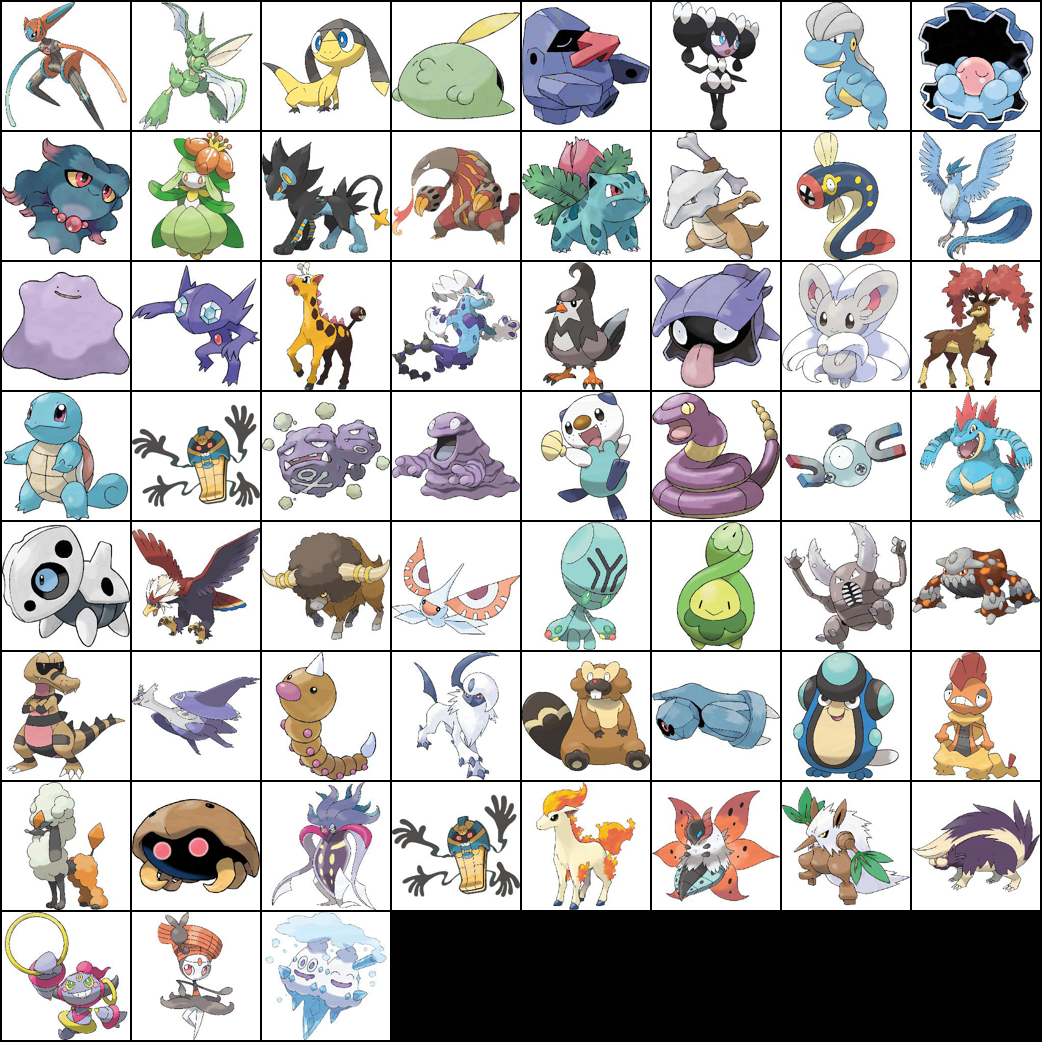

In [30]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images in Pk_dataloader:
    images = images.reshape(images.size(0), 3, 128, 128)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=8)
    break
    
Image(os.path.join(sample_dir, 'real_images.png'))

In [31]:
sample_vectors = get_noise()

In [33]:
def save_fake_images(index):
    fake_images = g_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 128, 128)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
#     print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

RuntimeError: shape '[64, 3, 128, 128]' is invalid for input of size 2899968

In [24]:
num_epochs = 5000
total_step = len(Pk_dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
print(total_step)

14


In [25]:
%%time
for epoch in range(num_epochs):
    for i, pokemon in enumerate(Pk_dataloader):

        d_loss, real_score, fake_score = train_discriminator(pokemon)
        g_loss, fake_images = train_generator()

        if (i+1) % 7 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    if epoch % 100 == 0:   
        fake_imgs = fake_images.cpu().data*0.5 + 0.5
        img = ToPILImage()(fake_imgs[3])
        
        img.save('./result/G_result/iter_%d.png'%(epoch))
        
        torch.save(d_model,'./result/D_checkpoint/iter_d_%d.pt'%(epoch))
        torch.save(g_model,'./result/G_checkpoint/iter_g_%d.pt'%(epoch))
        
    # Sample and save images
    save_fake_images(epoch+1)

KeyboardInterrupt: 